In [1]:
from lxml import etree
from datetime import datetime
import csv
import codecs
import ujson
import re
import pandas as pd

In [2]:
all_elements = {"article", "inproceedings", "proceedings", "book", "incollection", "phdthesis", 
                "mastersthesis", "www"}
all_features = {"address", "author", "booktitle", "cdrom", "chapter", "cite", "crossref", "editor", "ee", "isbn",
                "journal", "month", "note", "number", "pages", "publisher", "school", "series", "title", "url",
                "volume", "year"}

In [3]:
def log_msg(message):
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), message)
    
def context_iter(dblp_path):
    return etree.iterparse(source=dblp_path, dtd_validation=True, load_dtd=True)  # required dtd

def clear_element(element):
    element.clear()
    while element.getprevious() is not None:
        del element.getparent()[0]

In [4]:
def extract_feature(elem, features, include_key=False):
    if include_key:
        attribs = {'key': [elem.attrib['key']]}
    else:
        attribs = {}
    for feature in features:
        attribs[feature] = []
    for sub in elem:
        if sub.tag not in features:
            continue
        if sub.tag == 'title':
            text = re.sub("<.*?>", "", etree.tostring(sub).decode('utf-8')) if sub.text is None else sub.text
        elif sub.tag == 'pages':
            text = count_pages(sub.text)
        else:
            text = sub.text
        if text is not None and len(text) > 0:
            attribs[sub.tag] = attribs.get(sub.tag) + [text]
    return attribs

In [5]:
def count_pages(pages):
    cnt = 0
    for part in re.compile(r",").split(pages):
        subparts = re.compile(r"-").split(part)
        if len(subparts) > 2:
            continue
        else:
            try:
                re_digits = re.compile(r"[\d]+")
                subparts = [int(re_digits.findall(sub)[-1]) for sub in subparts]
            except IndexError:
                continue
            cnt += 1 if len(subparts) == 1 else subparts[1] - subparts[0] + 1
    return "" if cnt == 0 else str(cnt)

In [10]:
def parse_entity(dblp_path, save_path, type_name, features=None, save_to_csv=False, include_key=False):
    log_msg("PROCESS: Start parsing for {}...".format(str(type_name)))
    #i=0
    assert features is not None,
    results = []
    attrib_count, full_entity, part_entity = {}, 0, 0
    for _, elem in context_iter(dblp_path):
        if elem.tag in type_name:
            #print(elem.tag)
            #i+=1
            attrib_values = extract_feature(elem, features, include_key)
            attrib_values['type']=[]
            attrib_values['type'].append(elem.tag)
            #print(attrib_values)
            results.append(attrib_values)
            for key, value in attrib_values.items():
                attrib_count[key] = attrib_count.get(key, 0) + len(value)
            cnt = sum([1 if len(x) > 0 else 0 for x in list(attrib_values.values())])
            if cnt == len(features):
                full_entity += 1
            else:
                part_entity += 1
        elif elem.tag not in all_elements:
            continue
        clear_element(elem)
        '''if i > 10:
            break '''
    if save_to_csv:
        f = open(save_path, 'w', newline='', encoding='utf8')
        writer = csv.writer(f, delimiter=',')
        features.append('type')
        writer.writerow(features)
        for record in results:
            row = ['::'.join(v) for v in list(record.values())]
            writer.writerow(row)
        f.close()
    else:
        with codecs.open(save_path, mode='w', encoding='utf8', errors='ignore') as f:
            ujson.dump(results, f)
    return full_entity, part_entity, attrib_count

In [11]:
def parse_publications(dblp_path, save_path, save_to_csv=False, include_key=False):
    type_name = ['article', 'book', 'incollection', 'inproceedings']
    features = ['title', 'author', 'year', 'journal', 'pages']
    info = parse_entity(dblp_path, save_path, type_name, features, save_to_csv=save_to_csv, include_key=include_key)
    log_msg('Total publications found: {}, publications contain all features: {}, publications contain part of '
            'features: {}'.format(info[0] + info[1], info[0], info[1]))
    log_msg("Features information: {}".format(str(info[2])))

In [12]:
def main():
    dblp_path = 'dblp/dblp.xml'
    save_path = 'dblp/publications.csv'
    try:
        context_iter(dblp_path)
        log_msg("LOG: Successfully loaded \"{}\".".format(dblp_path))
    except IOError:
        log_msg("ERROR: Failed to load file \"{}\". Please check your XML and DTD files.".format(dblp_path))
        exit()
    parse_publications(dblp_path, save_path, save_to_csv=True)

In [13]:
if __name__ == '__main__':
    main()

2019-12-23 14:50:30 LOG: Successfully loaded "dblp/dblp.xml".
2019-12-23 14:50:30 PROCESS: Start parsing for ['article', 'book', 'incollection', 'inproceedings']...
2019-12-23 14:53:59 Total publications found: 4724195, publications contain all features: 2735193, publications contain part of features: 1989002
2019-12-23 14:53:59 Features information: {'title': 4724195, 'author': 14331144, 'year': 4724192, 'journal': 2145310, 'pages': 4255645, 'type': 4724195}


In [14]:
df= pd.read_csv('dblp/publications.csv',delimiter=',',encoding='utf8')

/home/dhananjay/genealogy/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
df['year']=df['year'].fillna('0000').astype(int)

In [41]:
publ_count=df.groupby(['year']).size().reset_index(name='counts')

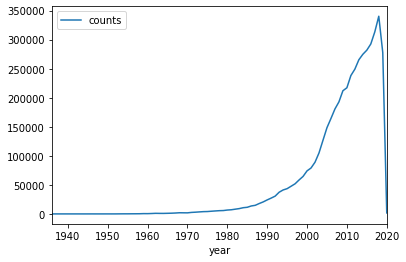

In [58]:
publ_count[publ_count['year']>1900].plot('year','counts')

In [49]:
df[df['type']=='article'].shape[0]

2145537

In [50]:
df[df['type']=='inproceedings'].shape[0]

2500668

In [51]:
df[df['type']=='incollection'].shape[0]

60150

In [52]:
df[df['type']=='book'].shape[0]

17840